Iteración 0: Mejor makespan = 110
Iteración 10: Mejor makespan = 105
Iteración 20: Mejor makespan = 100
Iteración 30: Mejor makespan = 100
Iteración 40: Mejor makespan = 100
Iteración 50: Mejor makespan = 100
Iteración 60: Mejor makespan = 100
Iteración 70: Mejor makespan = 100
Iteración 80: Mejor makespan = 100
Iteración 90: Mejor makespan = 100
[100]
[0.018]

Mejor solución encontrada: [3, 1, 3, 2, 1, 2, 1, 0, 3, 0]
Mejor makespan: 100


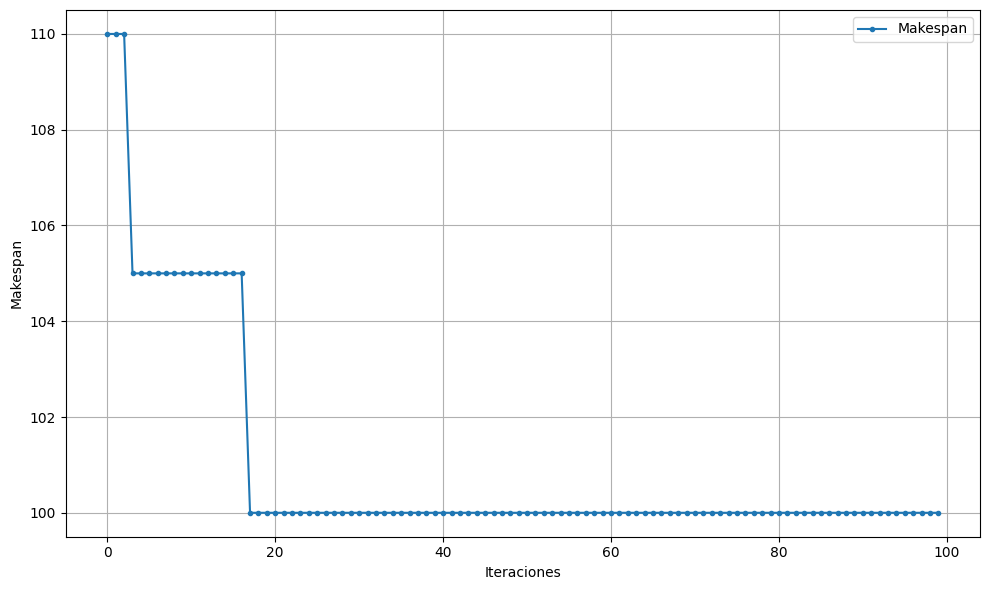

In [ ]:
import pandas as pd
import numpy as np
import random
import time

# Función para calcular el makespan
def calculate_makespan(solution, task_times, num_machines):
    machine_loads = [0] * num_machines
    for task_idx, machine_idx in enumerate(solution):
        machine_loads[machine_idx] += task_times[task_idx]
    return max(machine_loads)


# Inicializar la población de plantas
def initialize_population(pop_size, num_tasks, num_machines):
    return [
        [random.randint(0, num_machines - 1) for _ in range(num_tasks)]
        for _ in range(pop_size)
    ]


# Generar un vecino de una planta (mutación)
def generate_neighbor(plant, num_machines):
    neighbor = plant.copy()
    index_to_change = random.randint(0, len(plant) - 1)
    new_value = random.randint(0, num_machines - 1)
    while neighbor[index_to_change] == new_value:
        new_value = random.randint(0, num_machines - 1)
    neighbor[index_to_change] = new_value
    return neighbor


# Modelo Lotka-Volterra discreto
def lotka_volterra_discrete(x, y, model, params):
    a, b, c, d, e, f = (
        params["a"],
        params["b"],
        params["c"],
        params["d"],
        params["e"],
        params["f"],
    )

    if model == "predator_prey":
        x_next = x * (a - b * x - c * y)
        y_next = y * (d - e * x - f * y)
    elif model == "competitive":
        x_next = x * (a - b * x + c * y)
        y_next = y * (d + e * x - f * y)
    elif model == "cooperative":
        x_next = a * x - b * x * y
        y_next = d * x * y - c * y
    else:
        raise ValueError("Unknown model type")
    return max(x_next, 0), max(y_next, 0)


# Algoritmo DMOA
def dmoa(task_times, num_tasks, num_machines, pop_size, max_iter):
    start_time = time.time()
    # Inicializar poblaciones
    plant_population = initialize_population(pop_size, num_tasks, num_machines)
    hongo_population = [
        generate_neighbor(plant, num_machines) for plant in plant_population
    ]

    best_solution = None
    best_makespan = float("inf")
    progress = []  # Para seguimiento del progreso

    # Parámetros del modelo Lotka-Volterra
    params = {"a": 0.01, "b": 0.2, "c": 0.06, "d": 1.5, "e": 1, "f": 0.01}

    # Evaluar la población inicial
    fitness_plants = [
        calculate_makespan(ind, task_times, num_machines) for ind in plant_population
    ]
    fitness_hongos = [
        calculate_makespan(ind, task_times, num_machines) for ind in hongo_population
    ]
    for i, fit in enumerate(fitness_plants):
        if fit < best_makespan:
            best_makespan = fit
            best_solution = plant_population[i]
    # Mostrar en df cada individuo/fitness
    if pop_size < 20:
        plant_pop = pd.DataFrame()
        hongo_pop = pd.DataFrame()
        plant_pop["plants"] = plant_population
        plant_pop["fitness"] = fitness_plants
        hongo_pop["hongo"] = hongo_population
        hongo_pop["fitness"] = fitness_hongos

    # Iteraciones principales del algoritmo
    for t in range(max_iter):
        fitness_plants = [
            calculate_makespan(ind, task_times, num_machines)
            for ind in plant_population
        ]
        fitness_hongos = [
            calculate_makespan(ind, task_times, num_machines)
            for ind in hongo_population
        ]
        params["a"] = min(fitness_plants)
        params["d"] = min(fitness_hongos)
        for i in range(pop_size):
            # Aplicar modo cooperativo
            x, y = fitness_plants[i], fitness_hongos[i]
            new_x, new_y = lotka_volterra_discrete(x, y, "cooperative", params)
            # Comparar poblaciones y actualizar
            if new_x < new_y:
                fitness_plants[i] = new_x
                hongo_population[i] = plant_population[i]
            else:
                fitness_hongos[i] = new_y

            # Seleccionar modelo aleatorio
            random_model = random.choice(["predator_prey", "competitive"])
            new_x, new_y = lotka_volterra_discrete(new_x, new_y, random_model, params)

            # Generar vecino y evaluar
            neighbor = generate_neighbor(plant_population[i], num_machines)
            neighbor_fitness = calculate_makespan(neighbor, task_times, num_machines)

            if neighbor_fitness < fitness_plants[i]:
                plant_population[i] = neighbor
                fitness_plants[i] = neighbor_fitness

                if neighbor_fitness < best_makespan:
                    best_makespan = neighbor_fitness
                    best_solution = neighbor

        progress.append(best_makespan)
        if t % 10 == 0:
            print(f"Iteración {t}: Mejor makespan = {best_makespan}")
    total_time = time.time() - start_time
    return best_solution, best_makespan, progress, total_time


# Ejemplo de uso
task_times = [20, 35, 15, 45, 30, 55, 25, 40, 50, 60]  # Tiempos de las tareas
num_tasks = len(task_times)  # Número de tareas
num_machines = 4  # Número de máquinas
pop_size = 10  # Tamaño de la población
max_iter = 100  # Número máximo de iteraciones

# Ejecutar el algoritmo
soluciones = []
tiempos = []
for i in range(0, 1):
    best_solution, best_makespan, progress, totaltime = dmoa(
        task_times, num_tasks, num_machines, pop_size, max_iter
    )
    soluciones.append(best_makespan)
    tiempos.append(round(totaltime, 3))

print(soluciones)
print(tiempos)
# print(np.mean(tiempos))
# print(soluciones.count(95))

print("\nMejor solución encontrada:", best_solution)
print("Mejor makespan:", best_makespan)

# # Graficar el progreso
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(progress, "o-", markersize=3, label="Makespan")
plt.xlabel("Iteraciones")
plt.ylabel("Makespan")
# plt.title("Progreso del DMOA")
plt.tight_layout()
plt.legend()
plt.grid()
# plt.savefig(f'Metaheuristics/MOA/test_image-{date_plot}.png')
plt.show()


# Recocido simulado

Mejor solución encontrada (asignación de tareas a máquinas): [4, 3, 3, 1, 2, 4, 4, 1, 3, 2]
Distribucion de la carga: [85, 90, 100, 100]
Makespan mínimo estimado: 100


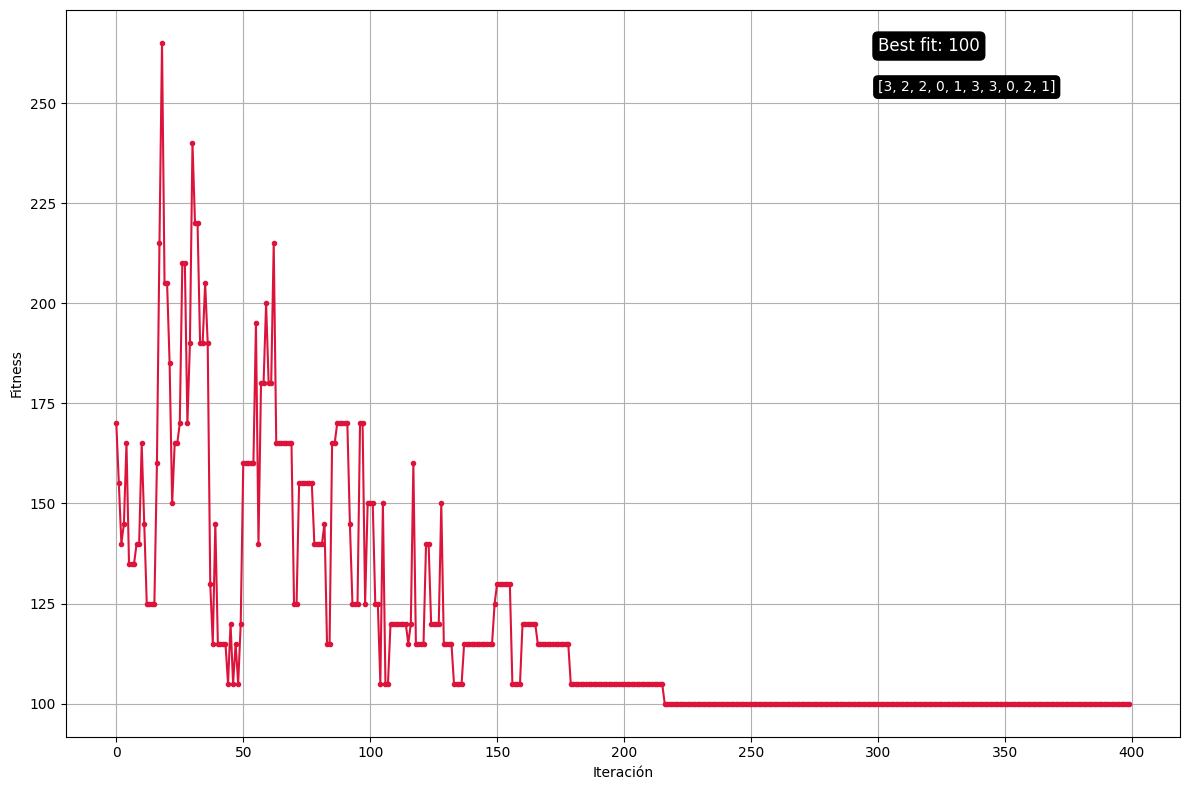

In [ ]:
# # MOA_Recocido.py
import numpy as np
import random
import matplotlib.pyplot as plt
import time


# Función de evaluación del makespan (la maquina que termine de ultimo)
def calculate_makespan(machine_loads):
    return max(machine_loads)


# Función para generar una solución inicial aleatoria
def generate_initial_solution(num_tasks, num_machines):
    # print(f"num_machines: {num_machines}")
    # print(f"num_tasks: {num_tasks}")
    init = [random.randint(0, num_machines - 1) for _ in range(num_tasks)]
    # print(f"initial sol: {init}")
    return init


# Función para generar un vecino (modificar la asignación de una tarea a otra máquina)
def generate_neighbor(solution, num_machines):
    new_solution = solution.copy()
    # print(f"old solution: {solution}")
    task_to_change = random.randint(0, len(solution) - 1)
    new_machine = random.randint(0, num_machines - 1)
    while new_machine == new_solution[task_to_change]:
        new_machine = random.randint(0, num_machines - 1)
    new_solution[task_to_change] = new_machine
    # print(f"solution fnl: {new_solution}")
    return new_solution


# Función para calcular la temperatura inicial para asegurar probabilidad del 90%
def calculate_initial_temperature(delta_e, p_initial):
    return -delta_e / np.log(p_initial)


best_sol = []


# Función principal del recocido simulado
def simulated_annealing(
    num_tasks, num_machines, task_times, initial_probability=0.9, max_iterations=400
):
    start_time = time.time()
    # Generar una solución inicial
    current_solution = generate_initial_solution(num_tasks, num_machines)
    current_machine_loads = [0] * num_machines  # [0, 0, 0, 0]
    for i, machine in enumerate(current_solution):
        current_machine_loads[machine] += task_times[i]
        # print(f"machine: {machine+1} -> {task_times[i]} ---- {current_machine_loads}")
    current_makespan = calculate_makespan(current_machine_loads)

    # Calcular la temperatura inicial
    delta_e = 30  # Diferencia estimada entre soluciones iniciales
    # temperature = calculate_initial_temperature(delta_e, initial_probability)
    # print(f"temp: {temperature}")
    temperature = 1500  # 1250

    # Parámetro de enfriamiento
    cooling_rate = 0.97

    best_solution = current_solution
    best_makespan = current_makespan

    # Variables para seguimiento
    accepted_worse_solutions = 0
    total_worse_solutions = 0
    accepted = []

    for iteration in range(max_iterations):
        # Generar una solución vecina
        neighbor_solution = generate_neighbor(current_solution, num_machines)
        neighbor_machine_loads = [0] * num_machines
        for i, machine in enumerate(neighbor_solution):
            neighbor_machine_loads[machine] += task_times[i]
        neighbor_makespan = calculate_makespan(neighbor_machine_loads)

        # Calcular diferencia de energía
        delta_makespan = neighbor_makespan - current_makespan

        # Aceptar solución vecina (criterio de Metropolis) si es mejor
        if delta_makespan < 0:  # Mejor solución
            current_solution = neighbor_solution
            current_makespan = neighbor_makespan
            current_machine_loads = neighbor_machine_loads

            # Actualizar la mejor solución
            if current_makespan < best_makespan:
                best_solution = current_solution
                best_makespan = current_makespan

        else:  # Peor solución
            total_worse_solutions += 1
            acceptance_probability = np.exp(-delta_makespan / temperature)
            if np.random.rand() < acceptance_probability:
                accepted.append(delta_makespan)
                current_solution = neighbor_solution
                current_makespan = neighbor_makespan
                current_machine_loads = neighbor_machine_loads
                accepted_worse_solutions += 1  # Contar aceptadas

        best_sol.append(current_makespan)
        # Reducir la temperatura
        temperature *= cooling_rate

        # Log iteración
        # if (iteration + 1) % 10 == 0:
        #     print(
        #         f"Iteración {iteration+1}: Makespan actual = {current_makespan}, Mejor makespan = {best_makespan}, Temp = {temperature}"
        #     )

    # print(
    #     f"Total worse accepted: {round( (accepted_worse_solutions/total_worse_solutions)*100,3)} % of {round((total_worse_solutions/max_iterations)*100,2)} %"
    # )
    # Verificar porcentaje de aceptacion de peores soluciones
    # print(f"accepted on {len(accepted)}")
    end_time = time.time() - start_time
    return best_solution, best_makespan, current_machine_loads, end_time


# Parámetros del problema
num_machines = 4
task_times = [20, 35, 15, 45, 30, 55, 25, 40, 50, 60]
num_tasks = len(task_times)

# Ejecutar el recocido simulado
soluciones = []
tiempos = []
# for i in range(0, 100):
best_solution, best_makespan, machine_load, end_time = simulated_annealing(
        num_tasks, num_machines, task_times
    )
# soluciones.append(best_makespan)
# tiempos.append(round(end_time, 5))

# print(soluciones)
# print(tiempos)

# print(np.mean(tiempos))
# print(np.std(tiempos))
# print(soluciones.count(95))
# Imprimir resultados finales
print(
    f"Mejor solución encontrada (asignación de tareas a máquinas): {[i + 1 for i in best_solution]}"
)
print(f"Distribucion de la carga: {machine_load}")
print(f"Makespan mínimo estimado: {best_makespan}")


plt.figure(figsize=(12, 8))
plt.plot([i for i in range(400)], best_sol, "o-", markersize=3, color="crimson")
plt.grid()
# plt.ylim(0, max(best_sol) + 10)
plt.text(
    300,
    max(best_sol) - 2,
    f"Best fit: {best_sol[len(best_sol)-1]}",
    color="white",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="black"),
)
plt.text(
    300,
    max(best_sol) - 12,
    best_solution,
    color="white",
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="black"),
)
plt.xlabel("Iteración")
plt.ylabel("Fitness")
# plt.title("Recocido simulado")
plt.tight_layout()
plt.show()
